<a href="https://colab.research.google.com/github/ggmeiner22/plot2csv/blob/main/generate_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import io
import math
import base64
import random
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import csv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!rm -rf /content/sample_data

In [2]:
CURVE_TYPES = ["linear", "quadratic", "exponential", "logarithmic", "sinusoid", "sigmoid"]
X_AXIS = np.arange(1, 21)


def set_seed(seed: int | None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)


def scale_to_axis(y_raw, low=1.0, high=20.0):
    y_raw = np.asarray(y_raw, dtype=float)
    ymin, ymax = np.min(y_raw), np.max(y_raw)
    if ymax - ymin < 1e-8:
        return np.ones_like(y_raw) * ((low + high) / 2.0)
    y_norm = (y_raw - ymin) / (ymax - ymin)
    return low + y_norm * (high - low)


def to_pixel(x_axis, y_axis, w, h):
    px = int(round((x_axis - 1) / 19.0 * (w - 1)))
    py = int(round((20.0 - y_axis) / 19.0 * (h - 1)))
    return px, py


def _to_hr_px(x_axis, y_axis, W, H):

    px = int(round((x_axis - 1) / 19.0 * (W - 1)))
    py = int(round((20.0 - y_axis) / 19.0 * (H - 1)))
    return px, py

def draw_curve_pretty(y_axis, img_size=50, stroke=2, with_markers=True):
    """
    Render a smooth, antialiased curve with markers at x=1..20.
    Internally draw at high-res and downsample to img_size.
    """
    # High-res canvas for anti-aliasing
    HR = 256
    W = H = HR
    line_w = 6
    marker_r = 7 if with_markers else 0

    # draw in high-res
    img_hr = Image.new("L", (W, H), color=255)
    dr = ImageDraw.Draw(img_hr)

    # Fine interpolation for a smooth curve
    x_fine = np.linspace(1, 20, 400)
    y_fine = np.interp(x_fine, X_AXIS, y_axis)
    pts = [_to_hr_px(x, y_fine[i], W, H) for i, x in enumerate(x_fine)]

    # Smooth polyline
    for (x0, y0), (x1, y1) in zip(pts[:-1], pts[1:]):
        dr.line((x0, y0, x1, y1), fill=0, width=line_w)

    # round markers at the 20 sample points
    if with_markers:
        for i, x in enumerate(X_AXIS):
            px, py = _to_hr_px(x, y_axis[i], W, H)
            dr.ellipse((px - marker_r, py - marker_r, px + marker_r, py + marker_r), outline=0, width=3, fill=None)

    # ownsample to the requested size with bicubic filter (anti-aliased)
    img = img_hr.resize((img_size, img_size), Image.BICUBIC)
    return img




def sample_params(curve_type):
    if curve_type == "linear":
        a = np.random.uniform(-3, 3)
        b = np.random.uniform(-10, 10)
        return a, b
    # a ∈ [−3, 3], b ∈ [−10, 10]
    # Example: y = 1.2x − 4

    if curve_type == "quadratic":
        a = np.random.uniform(-1.5, 1.5)
        b = np.random.uniform(-5, 5)
        c = np.random.uniform(-10, 10)
        return a, b, c
    if curve_type == "exponential":
        A = np.random.uniform(0.5, 3.0)
        k = np.random.uniform(-0.25, 0.25)
        c = np.random.uniform(-3, 3)
        return A, k, c
    if curve_type == "logarithmic":
        A = np.random.uniform(0.5, 5.0)
        shift = np.random.uniform(-2.0, 2.0)
        base = np.random.uniform(1.5, 4.0)
        c = np.random.uniform(-3, 3)
        return A, shift, base, c
    if curve_type == "sinusoid":
        A = np.random.uniform(1.0, 8.0)
        w = np.random.uniform(0.2, 1.0)
        phi = np.random.uniform(0, 2 * math.pi)
        c = np.random.uniform(-5, 5)
        return A, w, phi, c
    if curve_type == "sigmoid":
        A = np.random.uniform(5.0, 20.0)
        k = np.random.uniform(0.2, 1.0)
        x0 = np.random.uniform(5.0, 15.0)
        c = np.random.uniform(-5, 5)
        return A, k, x0, c
    raise ValueError(curve_type)


def gen_curve_values(curve_type, params):
    x = np.asarray(X_AXIS, dtype=float)
    if curve_type == "linear":
        a, b = params
        y = a * x + b
    elif curve_type == "quadratic":
        a, b, c = params
        y = a * x**2 + b * x + c
    elif curve_type == "exponential":
        A, k, c = params
        y = A * np.exp(k * x) + c
    elif curve_type == "logarithmic":
        A, shift, base, c = params
        z = np.maximum(x + shift, 1e-3)
        y = A * (np.log(z) / np.log(base)) + c
    elif curve_type == "sinusoid":
        A, w, phi, c = params
        y = A * np.sin(w * x + phi) + c
    elif curve_type == "sigmoid":
        A, k, x0, c = params
        y = A / (1.0 + np.exp(-k * (x - x0))) + c
    else:
        raise ValueError(curve_type)

    std = np.std(y)
    noise_sigma = 0.02 * std if std > 0 else 0.05
    y_noisy = y + np.random.normal(0, noise_sigma, size=y.shape)
    return scale_to_axis(y_noisy, 1.0, 20.0)


def generate_dataset(
    out_dir="/content/plot2csv_synth",
    n_per_type=200,
    img_size=50,
    jpeg_quality=90,
    seed=42,
    include_base64=True,
):
    set_seed(seed)
    out_dir = os.path.abspath(out_dir)
    img_dir = os.path.join(out_dir, "images")
    os.makedirs(img_dir, exist_ok=True)

    rows = []
    for curve_type in CURVE_TYPES:
        for i in range(n_per_type):

            # produces curve/formula
            params = sample_params(curve_type)
            # generates actual curve values based on forumla
            y_axis = gen_curve_values(curve_type, params)

            img = draw_curve_pretty(y_axis, img_size=img_size, stroke=random.choice([1, 1, 2]))

            fname = f"{curve_type}_{i:04d}.jpg"
            path = os.path.join(img_dir, fname)
            img.save(path, format="JPEG", quality=jpeg_quality, subsampling=1)

            if include_base64:
                with io.BytesIO() as buf:
                    img.save(buf, format="JPEG", quality=jpeg_quality, subsampling=1)
                    img_b64 = base64.b64encode(buf.getvalue()).decode("ascii")
            else:
                img_b64 = None

            row = {"type": curve_type, "image": path}
            if include_base64:
                row["image_b64_jpeg"] = img_b64

            for k, yval in enumerate(y_axis, start=1):
                row[f"y{k}"] = float(yval)
                row[f"y{k}_norm"] = float((yval - 1.0) / 19.0)

            rows.append(row)

    df = pd.DataFrame(rows)
    csv_path = os.path.join(out_dir, f"dataset_six_shapes_{len(df)}.csv")
    df.to_csv(csv_path, index=False)
    return csv_path

In [5]:
csv_path = generate_dataset(
    out_dir="/content/plot2csv_synth",  # output path
    n_per_type=200,
    img_size=50,
    jpeg_quality=90,
    seed=42,                           # or None for fresh randomness
    include_base64=True
)
csv_path

'/content/plot2csv_synth/dataset_six_shapes_1200.csv'

## Split into train/val and write two CSVs

In [7]:
assert os.path.exists(csv_path), f"Master CSV not found at {csv_path}. Run the data-gen cell first."
out_dir = os.path.dirname(csv_path)
print(f"Writing train/val splits to {out_dir}")

def write_splits(csv_path, out_dir, val_size=0.15, seed=42, make_rel_paths=True):
    df = pd.read_csv(csv_path)

    # columns: image, y1_norm ... y20_norm (plus y1 ... y20)
    needed = ["image"] + [f"y{k}_norm" for k in range(1, 21)]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {csv_path}: {missing}")

    if make_rel_paths:
        df["image"] = df["image"].apply(lambda p: os.path.relpath(p, start=out_dir))

    # Split
    train_df, val_df = train_test_split(
        df, test_size=val_size, random_state=seed, shuffle=True
    )

    # Create split dirs
    train_dir = os.path.join(out_dir, "train"); os.makedirs(train_dir, exist_ok=True)
    val_dir   = os.path.join(out_dir, "val");   os.makedirs(val_dir, exist_ok=True)

    # Write labels.csv for each split
    train_csv = os.path.join(train_dir, "labels.csv")
    val_csv   = os.path.join(val_dir, "labels.csv")
    train_df.to_csv(train_csv, index=False)
    val_df.to_csv(val_csv, index=False)

    print(f"Wrote:\n  {train_csv}\n  {val_csv}")
    return train_dir, val_dir

train_dir, val_dir = write_splits(csv_path, out_dir)


Writing train/val splits to /content/plot2csv_synth
Wrote:
  /content/plot2csv_synth/train/labels.csv
  /content/plot2csv_synth/val/labels.csv


In [8]:
# sanity check

df = pd.read_csv(csv_path)
print(df.head(),'\n')        # show first few rows
print(len(df),'\n')          # confirm total rows (1200)

print(pd.read_csv(os.path.join(train_dir, "labels.csv")).head(2),'\n')
print(pd.read_csv(os.path.join(val_dir, "labels.csv")).head(2))

     type                                           image  \
0  linear  /content/plot2csv_synth/images/linear_0000.jpg   
1  linear  /content/plot2csv_synth/images/linear_0001.jpg   
2  linear  /content/plot2csv_synth/images/linear_0002.jpg   
3  linear  /content/plot2csv_synth/images/linear_0003.jpg   
4  linear  /content/plot2csv_synth/images/linear_0004.jpg   

                                      image_b64_jpeg    y1  y1_norm  \
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgMCAgMDAw...  20.0      1.0   
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgMCAgMDAw...  20.0      1.0   
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgMCAgMDAw...  20.0      1.0   
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgMCAgMDAw...   1.0      0.0   
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgMCAgMDAw...   1.0      0.0   

          y2   y2_norm         y3   y3_norm         y4  ...        y16  \
0  19.105691  0.952931  17.909385  0.889968  16.914661  ...   5.040855   
1  19.074206  0.951274  17.926981  0.890894  17.101829  ..

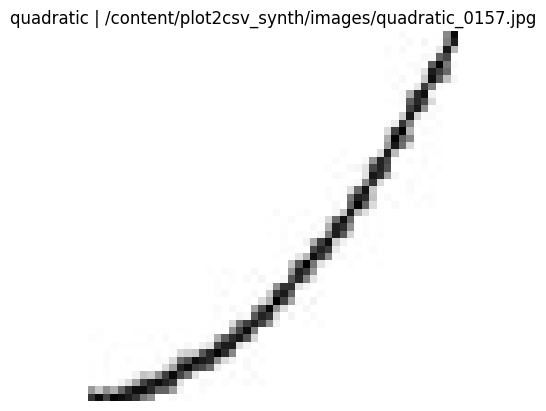

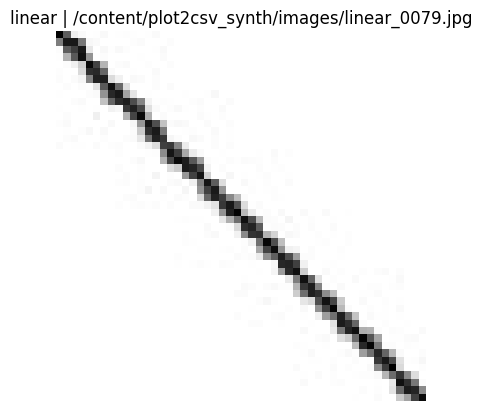

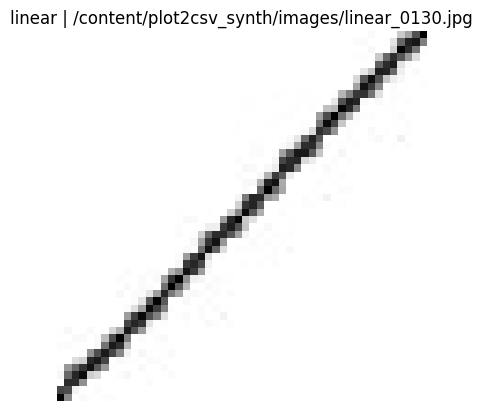

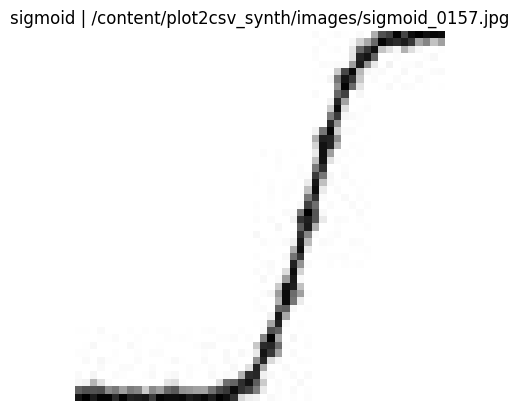

In [9]:
# Pick a few sample rows
sample_rows = df.sample(4)  # random 4 samples

for idx, row in sample_rows.iterrows():
    img = Image.open(row["image"])
    plt.imshow(img, cmap='gray')
    plt.title(f"{row['type']} | {row['image']}")
    plt.axis('off')
    plt.show()

## Minimal PyTorch Dataset & DataLoader (regression)

In [10]:
YCOLS = [f"y{k}_norm" for k in range(1, 21)]  # 20 normalized targets in [0,1]

class Plot2CSVDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.df = pd.read_csv(os.path.join(root_dir, "labels.csv"))
        # sanity check
        for c in ["image"] + YCOLS:
            assert c in self.df.columns, f"Missing column: {c}"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(os.path.dirname(self.root_dir), row["image"])
        img = Image.open(img_path).convert("L").resize((50, 50))
        x = np.asarray(img, dtype=np.float32) / 255.0
        x = np.expand_dims(x, 0)  # (1,50,50)
        y = row[YCOLS].to_numpy(dtype=np.float32)  # (20,)
        return torch.from_numpy(x), torch.from_numpy(y)

train_ds = Plot2CSVDataset(train_dir)
val_ds   = Plot2CSVDataset(val_dir)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False)

len(train_ds), len(val_ds)

(1020, 180)

## Lightweight CNN head → 20 outputs (Sigmoid), MSE loss

In [11]:
class TinyRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 25x25
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 12x12
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),    # (64,1,1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 20),
            nn.Sigmoid()  # keep outputs in [0,1]
        )

    def forward(self, x):
        feats = self.net(x)
        return self.head(feats)

model = TinyRegressor()
criterion = nn.MSELoss()         # regression
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
def denorm_axis(y_norm: np.ndarray) -> np.ndarray:
    # y_norm shape (..., 20) in [0,1] -> axis units [1,20]
    return 1.0 + 19.0 * y_norm

def batch_metrics_axis(pred_norm: torch.Tensor, true_norm: torch.Tensor, thresholds=(0.5, 1.0, 2.0)):
    """
    pred_norm, true_norm: shape (B, 20) in [0,1] torch tensors
    Returns dict with MAE, RMSE, R^2 and 'hit rate' within thresholds (axis units).
    """
    # to cpu numpy
    p = pred_norm.detach().cpu().numpy()
    t = true_norm.detach().cpu().numpy()

    # convert to axis units
    p_ax = denorm_axis(p)
    t_ax = denorm_axis(t)

    # errors
    err = p_ax - t_ax
    abs_err = np.abs(err)
    mae = float(abs_err.mean())
    rmse = float(np.sqrt((err ** 2).mean()))

    # R^2 over all points in the batch (flatten all y’s)
    # Handle constant target edge-case
    t_flat = t_ax.reshape(-1)
    p_flat = p_ax.reshape(-1)
    sse = float(np.sum((t_flat - p_flat) ** 2))
    t_mean = float(np.mean(t_flat))
    sst = float(np.sum((t_flat - t_mean) ** 2))
    r2 = float(1.0 - sse / sst) if sst > 0 else float("nan")

    # Point-wise hit rates: % of individual y points within ±threshold
    hit_rates = {}
    for th in thresholds:
        hit_rates[f"hit@±{th}"] = float((abs_err <= th).mean())

    # Curve-wise hit rate: % of curves where *all 20 points* are within ±threshold
    curve_hits = {}
    for th in thresholds:
        curve_hits[f"curve_hit@±{th}"] = float((abs_err.max(axis=1) <= th).mean())

    return {
        "MAE_axis": mae,
        "RMSE_axis": rmse,
        "R2_axis": r2,
        **hit_rates,
        **curve_hits,
    }

# Helper: pick a validation index and display image + curves
def show_val_sample(idx=0):
    # 1) Load image path from the validation dataframe
    row = val_ds.df.iloc[idx]
    img_rel = row["image"]  # e.g., "images/xxxx.png"
    img_path = os.path.join(os.path.dirname(val_dir), img_rel)  # root/images/...

    # 2) Open the original plot image (as used by the model)
    img = Image.open(img_path).convert("L").resize((50, 50))

    # 3) Build the model input just like Dataset does
    x = (np.asarray(img, dtype=np.float32) / 255.0)[None, None, ...]  # (1,1,50,50)
    x_t = torch.from_numpy(x).to(device)

    # 4) Get prediction and ground-truth for this exact sample
    model.eval()
    with torch.no_grad():
        yhat = model(x_t).cpu().numpy().squeeze(0)  # normalized [0,1], shape (20,)

    y_true = row[[f"y{k}_norm" for k in range(1, 21)]].to_numpy(np.float32)

    # 5) Denormalize to axis units [1,20]
    def denorm_axis(y_norm: np.ndarray) -> np.ndarray:
        return 1.0 + 19.0 * y_norm

    y_pred_axis = denorm_axis(yhat)
    y_true_axis = denorm_axis(y_true)
    xs = np.arange(1, 21)

    # === First figure: the actual input image ===
    plt.figure()
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"Validation image (idx={idx})\n{img_rel}")

    # === Second figure: predicted vs. ground-truth curve ===
    plt.figure()
    plt.plot(xs, y_true_axis, marker="o", label="true")
    plt.plot(xs, y_pred_axis, marker="x", label="pred")
    plt.xlabel("x")
    plt.ylabel("y (axis units)")
    plt.title(f"Validation sample (idx={idx})")
    plt.legend()
    plt.show()

In [38]:
# === Full validation pass with metrics ===
def evaluate_val(loader):
    model.eval()
    all_stats = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            yhat = model(xb)               # normalized predictions
            stats = batch_metrics_axis(yhat, yb)
            all_stats.append(stats)

    # average the dicts
    keys = all_stats[0].keys()
    summary = {k: float(np.mean([d[k] for d in all_stats if np.isfinite(d[k])])) for k in keys}
    return summary

val_metrics = evaluate_val(val_loader)
print("Validation metrics (axis units):")
for k, v in val_metrics.items():
    print(f"  {k:>14}: {v:.4f}")

Validation metrics (axis units):
        MAE_axis: 6.1271
       RMSE_axis: 6.7975
         R2_axis: -0.0124
        hit@±0.5: 0.0312
        hit@±1.0: 0.0664
        hit@±2.0: 0.1359
  curve_hit@±0.5: 0.0000
  curve_hit@±1.0: 0.0000
  curve_hit@±2.0: 0.0000


In [39]:

from torch.utils.data import Dataset, DataLoader

class WithIndex(Dataset):
    def __init__(self, base_ds):
        self.base = base_ds
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        x, y = self.base[idx]
        return x, y, idx

# Wrap existing validation dataset
val_ds_idx = WithIndex(val_ds)
val_loader_idx = DataLoader(val_ds_idx, batch_size=val_loader.batch_size, shuffle=False, num_workers=val_loader.num_workers)


In [41]:

import numpy as np
import pandas as pd
import torch

@torch.no_grad()
def evaluate_val_detailed(loader_with_idx, model, device, thresholds=(0.5, 1.0, 2.0)):
    model.eval()
    rows = []
    for xb, yb, idx in loader_with_idx:
        xb, yb = xb.to(device), yb.to(device)
        yhat = model(xb)  # normalized predictions in [0,1]
        # Get batch-level metrics dict, but we want per-sample → loop within batch
        p = yhat.detach().cpu()
        t = yb.detach().cpu()
        for i in range(p.size(0)):
            stats = batch_metrics_axis(p[i:i+1], t[i:i+1], thresholds=thresholds)
            stats["dataset_idx"] = int(idx[i])
            rows.append(stats)
    df = pd.DataFrame(rows)
    return df


In [34]:

families = val_ds.df["type"].to_numpy()



In [42]:
# Run detailed eval, then aggregate by family
detailed = evaluate_val_detailed(val_loader_idx, model, device)

# Join per-sample family
detailed["family"] = detailed["dataset_idx"].map(lambda i: families[i])

# Overall (already have your existing evaluate_val summary)
overall = evaluate_val(val_loader)

# Per-family means
per_family = (detailed
              .groupby("family", as_index=False)
              .mean(numeric_only=True)
              .sort_values("MAE_axis"))

print("\n=== Overall (from your evaluate_val) ===")
for k, v in overall.items():
    print(f"{k:>16}: {v:.4f}")

print("\n=== Per-family performance (means) ===")
print(per_family[["family","MAE_axis","RMSE_axis","R2_axis",
                  "hit@±0.5","hit@±1.0","hit@±2.0",
                  "curve_hit@±0.5","curve_hit@±1.0","curve_hit@±2.0"]])



=== Overall (from your evaluate_val) ===
        MAE_axis: 6.1271
       RMSE_axis: 6.7975
         R2_axis: -0.0124
        hit@±0.5: 0.0312
        hit@±1.0: 0.0664
        hit@±2.0: 0.1359
  curve_hit@±0.5: 0.0000
  curve_hit@±1.0: 0.0000
  curve_hit@±2.0: 0.0000

=== Per-family performance (means) ===
        family  MAE_axis  RMSE_axis   R2_axis  hit@±0.5  hit@±1.0  hit@±2.0  \
1       linear  4.986778   5.760272 -0.001801  0.045588  0.113235  0.202941   
3    quadratic  5.915662   6.615878 -0.272869  0.035526  0.071053  0.157895   
0  exponential  5.960523   6.603366 -0.427931  0.035185  0.070370  0.131481   
5     sinusoid  6.066827   6.746754 -0.027868  0.037037  0.059259  0.135185   
2  logarithmic  6.468966   6.994183 -1.368341  0.019231  0.050000  0.100000   
4      sigmoid  7.234333   7.722692 -0.157705  0.016071  0.042857  0.082143   

   curve_hit@±0.5  curve_hit@±1.0  curve_hit@±2.0  
1             0.0             0.0             0.0  
3             0.0             0.0 

In [29]:
@torch.no_grad()
def evaluate_val_global(loader, model, device):
    model.eval()
    preds = []
    trues = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        yhat = model(xb)            # normalized
        preds.append(yhat.cpu())
        trues.append(yb.cpu())
    p = torch.cat(preds, dim=0)
    t = torch.cat(trues, dim=0)
    return batch_metrics_axis(p, t)  # computes MAE/RMSE and a single global R²


## Simple training/validation loop

In [12]:
def run_epoch(loader, train=True):
    model.train(train)
    total = 0.0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            if train:
                optimizer .zero_grad()
                loss.backward()
                optimizer .step()
            total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

# Change to determine # of images trained
epochs = 50
for ep in range(1, epochs+1):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader,   train=False)
    val_metrics = evaluate_val(val_loader)
    print(f"epoch {ep:02d} | train MSE {tr:.5f} | val MSE {va:.5f} | "
          f"MAE_axis {val_metrics['MAE_axis']:.3f} | hit@±1 {val_metrics['hit@±1.0']:.2%} | "
          f"curve_hit@±1 {val_metrics['curve_hit@±1.0']:.1%}")

epoch 01 | train MSE 0.12275 | val MSE 0.11989 | MAE_axis 5.990 | hit@±1 6.55% | curve_hit@±1 0.0%
epoch 02 | train MSE 0.11667 | val MSE 0.11866 | MAE_axis 5.821 | hit@±1 7.24% | curve_hit@±1 0.0%
epoch 03 | train MSE 0.11442 | val MSE 0.11631 | MAE_axis 5.846 | hit@±1 6.31% | curve_hit@±1 0.0%
epoch 04 | train MSE 0.11418 | val MSE 0.11599 | MAE_axis 5.810 | hit@±1 6.54% | curve_hit@±1 0.0%
epoch 05 | train MSE 0.11361 | val MSE 0.11532 | MAE_axis 5.781 | hit@±1 6.34% | curve_hit@±1 0.0%
epoch 06 | train MSE 0.11233 | val MSE 0.11422 | MAE_axis 5.747 | hit@±1 6.44% | curve_hit@±1 0.0%
epoch 07 | train MSE 0.11082 | val MSE 0.11189 | MAE_axis 5.702 | hit@±1 6.73% | curve_hit@±1 0.0%
epoch 08 | train MSE 0.10785 | val MSE 0.10708 | MAE_axis 5.585 | hit@±1 6.97% | curve_hit@±1 0.0%
epoch 09 | train MSE 0.10143 | val MSE 0.09764 | MAE_axis 5.281 | hit@±1 8.12% | curve_hit@±1 0.0%
epoch 10 | train MSE 0.09056 | val MSE 0.08535 | MAE_axis 4.865 | hit@±1 9.18% | curve_hit@±1 0.0%
epoch 11 |

In [13]:
model.eval()
with torch.no_grad():
    xb, yb = next(iter(val_loader))
    xb = xb.to(device)
    yhat = model(xb).cpu().numpy()        # normalized [0,1]
    y_true = yb.numpy()                   # normalized [0,1]
    yhat_axis = 1.0 + 19.0 * yhat         # back to [1,20]
    ytrue_axis = 1.0 + 19.0 * y_true

print("Sample #0 (first three y's):")
print(" pred:", np.round(yhat_axis[0][:3], 3))
print(" true:", np.round(ytrue_axis[0][:3], 3))

Sample #0 (first three y's):
 pred: [1.089 3.58  5.232]
 true: [1.    1.396 2.639]


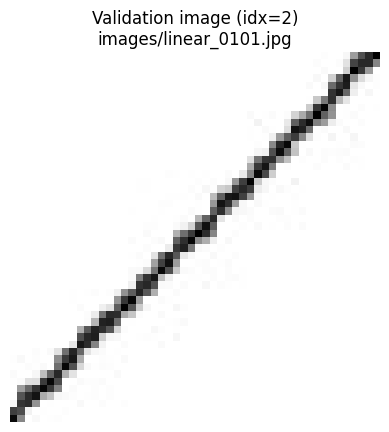

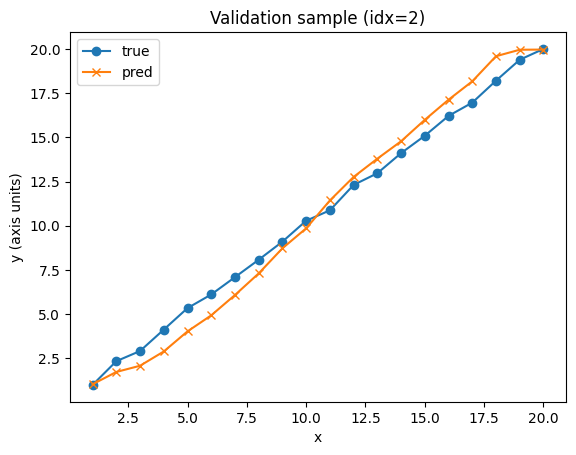

In [14]:
# Show a validation sample
show_val_sample(idx=2)

## Export predictions to CSV (end-to-end demo)

In [15]:
def predict_to_csv(img_path_list, out_csv="predictions.csv"):
    model.eval()
    rows = []
    with torch.no_grad():
        for p in img_path_list:
            img = Image.open(p).convert("L").resize((50, 50))
            x = torch.from_numpy((np.asarray(img, np.float32)/255.0)[None,None])
            yhat = model(x).squeeze(0).cpu().numpy()
            # unnormalize back to axis units y = 1 + 19*y_norm
            y_axis = 1.0 + 19.0 * yhat
            row = {"image": p}
            for k, v in enumerate(y_axis, start=1):
                row[f"y{k}"] = float(v)
            rows.append(row)
    with open(out_csv, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["image"]+[f"y{k}" for k in range(1,21)])
        writer.writeheader(); writer.writerows(rows)
    return out_csv

val_df = pd.read_csv(os.path.join(val_dir, "labels.csv"))
root = os.path.dirname(val_dir)
sample_imgs = [os.path.join(root, p) for p in val_df["image"].head(5).tolist()]
predict_to_csv(sample_imgs, out_csv="val_samples_predictions.csv")


'val_samples_predictions.csv'